# Определение стоимости автомобилей для сервиса "Не бит Не крашен"

**Описание:** Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 

**Цель проекта:** Построить модель, которая сможет определить стоимость автомобиля на основании предоставленных данных. 

**Ход исследования:** 
1. Загрузка и предобработка данных
2. Исследовательский анализ данных
3. Подготовка данных для обучения моделей
4. Обучение моделей
5. Анализ времени обучения, времени предсказаний и качества моделей
6. Выбор лучшей модели. Проверка качества на тестовой выборке

**Вывод**

## 1 Загрузка и предобработка данных

Загрузим необходимые библиотеки и инструменты для работы

In [1]:
# загрузка бибилиотек
!pip install phik -q
!pip install -Uq scikit-learn
!pip install lightgbm -q

In [2]:
#импорт бибилиотек для работы с датасетами
import pandas as pd
import numpy as np

import phik
from phik.report import plot_correlation_matrix

# импорт библиотек для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# импорт бибилотек МО
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb

# импорт инструментов для предобработки данных для МО
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import (StandardScaler, OneHotEncoder)
from sklearn.base import BaseEstimator, TransformerMixin

# импорт метрик
from sklearn.metrics import root_mean_squared_error

# импорт библиотек для пайплайна
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [3]:
try:
    autos = pd.read_csv('C:/Users/anysh/Desktop/Практикум/11. Численные методы/autos.csv',\
                    parse_dates=['DateCrawled', 'DateCreated','LastSeen'])
except:
    autos = pd.read_csv('/datasets/autos.csv')

In [4]:
autos.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Данные загружены, можно переходить к предобработке пустых и аномальных значений.

In [5]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Преобразуем значения дат - округлим их до месяца

In [6]:
autos['DateCrawled'] = autos['DateCrawled'].values.astype('datetime64[M]')
autos['DateCreated'] = autos['DateCreated'].values.astype('datetime64[M]')
autos['LastSeen'] = autos['LastSeen'].values.astype('datetime64[M]')

autos['DateCrawled'] = autos['DateCrawled'].dt.floor('D')
autos['DateCreated'] = autos['DateCreated'].dt.floor('D')
autos['LastSeen'] = autos['LastSeen'].dt.floor('D')

Все данные соотвествуют своим типам, посмотрим на количество пропусков (мы видим, что они тут есть)

### 1.1 Обработка пропущенных значений

In [7]:
autos.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-01,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-01,0,70435,2016-04-01
1,2016-03-01,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-01,0,66954,2016-04-01
2,2016-03-01,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-01,0,90480,2016-04-01
3,2016-03-01,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-01,0,91074,2016-03-01
4,2016-03-01,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-01,0,60437,2016-04-01


In [8]:
autos.isna().sum(), round(autos.isna().sum()/autos.shape[0] * 100, 2)

(DateCrawled              0
 Price                    0
 VehicleType          37490
 RegistrationYear         0
 Gearbox              19833
 Power                    0
 Model                19705
 Kilometer                0
 RegistrationMonth        0
 FuelType             32895
 Brand                    0
 Repaired             71154
 DateCreated              0
 NumberOfPictures         0
 PostalCode               0
 LastSeen                 0
 dtype: int64,
 DateCrawled           0.00
 Price                 0.00
 VehicleType          10.58
 RegistrationYear      0.00
 Gearbox               5.60
 Power                 0.00
 Model                 5.56
 Kilometer             0.00
 RegistrationMonth     0.00
 FuelType              9.28
 Brand                 0.00
 Repaired             20.08
 DateCreated           0.00
 NumberOfPictures      0.00
 PostalCode            0.00
 LastSeen              0.00
 dtype: float64)

In [9]:
1 - (autos.dropna(axis='rows').shape[0] / autos.shape[0])

0.30633322892239445

Удалять бездумно все пропуски мы не будем - их **31%** от всего датасета (нам важно стремиться убирать совокупно не больше **2%**).

Посмотрим, в каких признаках у нас много пропусков:

- `VehicleType` - тип автомобильного кузова - 10.58%
- `Gearbox` - тип коробки передач - 5.6%
- `Model` - модель автомобиля - 5.56%
- `FuelType` - тип топлива - 9.28%
- `Repaired` - была машина в ремонте или нет - 20.08%

Посмотрим, какие там есть уникальные значения.

In [10]:
autos['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [11]:
autos['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [12]:
autos['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [13]:
autos['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [14]:
pd.Series(autos['Model'].unique()).sort_values()

59         100
232        145
58         147
41         156
130        159
        ...   
92        yeti
150    ypsilon
60     z_reihe
74      zafira
1          NaN
Length: 251, dtype: object

In [15]:
autos[autos['Model'] == 'other'].head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7,2016-03-01,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-01,0,19348,2016-03-01
24,2016-03-01,500,sedan,1990,manual,118,other,150000,10,petrol,mercedes_benz,yes,2016-03-01,0,35390,2016-03-01
38,2016-04-01,11900,other,2002,manual,129,other,150000,11,gasoline,volkswagen,no,2016-04-01,0,10551,2016-04-01
39,2016-03-01,1500,bus,1984,manual,70,other,150000,8,gasoline,mercedes_benz,no,2016-03-01,0,22767,2016-03-01
52,2016-04-01,1400,NaN,2016,manual,55,other,5000,1,NaN,hyundai,NaN,2016-04-01,0,34454,2016-04-01


Резюмируем:
1. `VehicleType` и `FuelType`, `Model` - поставим значение `other`
2. `Repaired`, `Gearbox` - `not_defined` (не определено)

In [16]:
autos[['VehicleType', 'FuelType', 'Model']] = autos[['VehicleType', 'FuelType', 'Model']].fillna(value='other')
autos[['Repaired', 'Gearbox']] = autos[['Repaired', 'Gearbox']].fillna(value='not_defined')

In [17]:
autos.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

С пропусками разобрались, перейдем к явным дубликатам

### 1.2 Обработка дубликатов

In [18]:
autos.duplicated().sum()

17834

In [19]:
autos[autos.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
3551,2016-03-01,1670,sedan,1999,manual,75,golf,150000,8,petrol,volkswagen,no,2016-03-01,0,52388,2016-03-01
3786,2016-03-01,2999,sedan,2002,manual,101,golf,150000,6,gasoline,volkswagen,no,2016-03-01,0,32756,2016-03-01
4222,2016-03-01,14500,wagon,2007,manual,140,a6,100000,3,gasoline,audi,no,2016-03-01,0,94060,2016-04-01
4300,2016-03-01,1250,wagon,2000,manual,131,mondeo,150000,7,petrol,ford,no,2016-03-01,0,17389,2016-04-01
4604,2016-03-01,7000,suv,2006,manual,177,rav,150000,0,gasoline,toyota,no,2016-03-01,0,51105,2016-04-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354336,2016-03-01,3299,other,2005,auto,0,outlander,150000,4,petrol,mitsubishi,not_defined,2016-03-01,0,17034,2016-03-01
354337,2016-03-01,11500,sedan,2004,auto,445,7er,125000,0,petrol,bmw,not_defined,2016-03-01,0,4107,2016-04-01
354352,2016-03-01,6500,sedan,2003,auto,145,e_klasse,150000,3,gasoline,mercedes_benz,no,2016-03-01,0,60437,2016-03-01
354355,2016-03-01,4400,sedan,2008,manual,105,leon,150000,7,gasoline,seat,no,2016-03-01,0,45896,2016-04-01


Удалим такие дубликаты

In [20]:
autos = autos.drop_duplicates(keep='first').reset_index(drop=True)

In [21]:
autos.duplicated().sum()

0

Перейдем к неявным дубликатам. Нам необходимо посмотреть столбцы `Model`, `Brand`, чтобы исключить задвоения.

In [22]:
autos['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

Здесь неявных дубликатов нет, перейдем к моделям.

In [23]:
pd.Series(autos['Model'].unique()).sort_values().tolist()

['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

In [24]:
len(autos['Model'].unique())

250

In [25]:
autos['Model'] = autos['Model'].replace('range_rover', 'rangerover')

In [26]:
len(autos['Model'].unique())

249

Заменили одно значение. Зато у нас есть большая выборка с уникальными значениями параметров)

Посмотрим на уникалные значения по типу топлива.

In [27]:
autos['FuelType'].unique()

array(['petrol', 'gasoline', 'other', 'lpg', 'hybrid', 'cng', 'electric'],
      dtype=object)

Заменим petrol на gasoline.

In [28]:
autos['FuelType'] = autos['FuelType'].replace('petrol', 'gasoline')
autos['FuelType'].unique()

array(['gasoline', 'other', 'lpg', 'hybrid', 'cng', 'electric'],
      dtype=object)

### 1.3 Обработка аномальных значений

Посмотрим на аномальные значения все дискретные признаки.
В нашем случае это: `RegistrationYear`, `RegistrationMonth`, `Kilometer`, `Power`.

In [29]:
pd.Series(autos['RegistrationYear'].unique()).sort_values().tolist()

[1000,
 1001,
 1039,
 1111,
 1200,
 1234,
 1253,
 1255,
 1300,
 1400,
 1500,
 1600,
 1602,
 1688,
 1800,
 1910,
 1915,
 1919,
 1920,
 1923,
 1925,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2222,
 2290,
 2500,
 2800,
 2900,
 3000,
 3200,
 3500,
 3700,
 3800,
 4000,
 4100,
 4500,
 4800,
 5000,
 5300,
 5555,
 5600,
 5900,
 5911,
 6000,
 6500,
 7000,
 7100,
 7500,
 7800,
 8000,
 8200,

Есть много аномальных значений. Интересно, что за автомобили продаются с датой регистрации в 1910 году

In [30]:
autos[autos['RegistrationYear'] == 1910]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
15,2016-03-01,450,small,1910,not_defined,0,ka,5000,0,gasoline,ford,not_defined,2016-03-01,0,24148,2016-03-01
6622,2016-04-01,0,small,1910,not_defined,0,other,5000,1,other,sonstige_autos,not_defined,2016-04-01,0,93105,2016-04-01
6968,2016-03-01,135,other,1910,not_defined,0,other,5000,0,other,opel,not_defined,2016-03-01,0,19374,2016-04-01
10160,2016-03-01,1250,other,1910,not_defined,0,other,5000,0,other,audi,not_defined,2016-03-01,0,18445,2016-04-01
17952,2016-03-01,1,other,1910,not_defined,0,other,5000,0,other,volkswagen,not_defined,2016-03-01,0,50829,2016-04-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306852,2016-03-01,0,small,1910,manual,600,other,150000,5,other,volkswagen,yes,2016-03-01,0,35764,2016-03-01
317101,2016-03-01,0,suv,1910,manual,0,other,5000,0,other,toyota,not_defined,2016-03-01,0,48683,2016-03-01
318818,2016-03-01,1300,other,1910,not_defined,0,other,5000,9,other,audi,not_defined,2016-03-01,0,82256,2016-04-01
326304,2016-04-01,1,other,1910,not_defined,0,other,5000,1,other,volkswagen,not_defined,2016-04-01,0,18273,2016-04-01


Разделим года по категориям и посмотрим в % соотношении, какие категории нам стоит взять в разработку.

In [31]:
pd.cut(autos['RegistrationYear'], bins=5)

0         (991.001, 2799.8]
1         (991.001, 2799.8]
2         (991.001, 2799.8]
3         (991.001, 2799.8]
4         (991.001, 2799.8]
                ...        
336530    (991.001, 2799.8]
336531    (991.001, 2799.8]
336532    (991.001, 2799.8]
336533    (991.001, 2799.8]
336534    (991.001, 2799.8]
Name: RegistrationYear, Length: 336535, dtype: category
Categories (5, interval[float64]): [(991.001, 2799.8] < (2799.8, 4599.6] < (4599.6, 6399.4] < (6399.4, 8199.2] < (8199.2, 9999.0]]

In [32]:
def categories(x):
    if x <= 1932:
        return '1910-1932'
    if 1932<x<=1954:
        return '1933-1954'
    if 1954<x<=1975:
        return '1955-1974'
    if 1975<x<=1997:
        return '1975-1997'
    if 1997<x<=2019:
        return '1998-2019'
    else:
        return 'not_defined'

In [33]:
autos['year_category'] = autos['RegistrationYear'].apply(categories)

In [34]:
apv = autos.pivot_table(index='year_category', values='Brand', aggfunc='count')
apv.rename(columns={'Brand': 'Количество, шт'}, inplace=True)
apv.rename_axis(index={'year_category': 'Год'}, inplace=True)

apv['Соотношение, %'] = round(apv['Количество, шт'] / apv['Количество, шт'].sum(), 2) * 100
apv

,"Количество, шт","Соотношение, %"
Год,,
1910-1932,184,0.0
1933-1954,120,0.0
1955-1974,2178,1.0
1975-1997,56640,17.0
1998-2019,277313,82.0
not_defined,100,0.0


In [35]:
autos_real = autos[autos['RegistrationYear'] >= 1910]
autos_real = autos_real[autos_real['RegistrationYear'] <= 2016]
(1 - autos_real.shape[0] / autos.shape[0]) * 100

4.18232873252411

Предлагаем в дальнейшем использовать значения за период с 1910 по 2016 год - такой год у нас стоит в датах создания и загрузки анкет.

In [36]:
autos = autos.query('1910 <= RegistrationYear <= 2016')

In [37]:
pd.cut(autos['RegistrationYear'], bins=5)

0         (1973.6, 1994.8]
1         (1994.8, 2016.0]
2         (1994.8, 2016.0]
3         (1994.8, 2016.0]
4         (1994.8, 2016.0]
                ...       
336530    (1994.8, 2016.0]
336531    (1994.8, 2016.0]
336532    (1994.8, 2016.0]
336533    (1994.8, 2016.0]
336534    (1994.8, 2016.0]
Name: RegistrationYear, Length: 322460, dtype: category
Categories (5, interval[float64]): [(1909.894, 1931.2] < (1931.2, 1952.4] < (1952.4, 1973.6] < (1973.6, 1994.8] < (1994.8, 2016.0]]

In [38]:
def categories(x):
    if 1910 <= x < 1985:
        return '1910-1985'
    if 1985 <= x < 1995:
        return '1985-1995'
    if 1995 <= x < 2005:
        return '1995-2005'
    if 2005 <= x < 2015:
        return '2005-2016'

In [39]:
autos['year_category'] = autos['RegistrationYear'].apply(categories)
autos.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,year_category
0,2016-03-01,480,other,1993,manual,0,golf,150000,0,gasoline,volkswagen,not_defined,2016-03-01,0,70435,2016-04-01,1985-1995
1,2016-03-01,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-01,0,66954,2016-04-01,2005-2016
2,2016-03-01,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,not_defined,2016-03-01,0,90480,2016-04-01,1995-2005
3,2016-03-01,1500,small,2001,manual,75,golf,150000,6,gasoline,volkswagen,no,2016-03-01,0,91074,2016-03-01,1995-2005
4,2016-03-01,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-01,0,60437,2016-04-01,2005-2016


Также если год регистрации автомобиля - 2016, нам важно учесть, что месяц регистрации не старше 4-го месяца.

In [40]:
autos[autos['RegistrationYear'] == 2016]['RegistrationMonth'].unique()

array([ 0,  6,  4,  1,  3,  9, 12, 10,  5,  8,  7, 11,  2])

In [41]:
autos[(autos['RegistrationYear'] == 2016) & (autos['RegistrationMonth'] > 4)].shape[0] / autos.shape[0] * 100

1.4203312038702474

Таких значений меньше 2%. Удалим их.

In [42]:
autos = autos[~((autos['RegistrationYear'] == 2016) & (autos['RegistrationMonth'] > 4))]

In [43]:
autos[autos['RegistrationYear'] == 2016]['RegistrationMonth'].unique()

array([0, 4, 1, 3, 2])

Годы обработали, перейдем к пробегу

In [44]:
pd.Series(autos['Kilometer'].unique()).sort_values().tolist()

[5000,
 10000,
 20000,
 30000,
 40000,
 50000,
 60000,
 70000,
 80000,
 90000,
 100000,
 125000,
 150000]

In [45]:
def kilometers(x):
    if 5000 <= x < 50000:
        return '5 000 - 50 000'
    if 50000 <= x < 100000:
        return '50 000 - 100 000'
    else:
        return '100 000 - 150 000'

In [46]:
autos['kilometer_category'] = autos['Kilometer'].apply(kilometers)
autos.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,year_category,kilometer_category
0,2016-03-01,480,other,1993,manual,0,golf,150000,0,gasoline,volkswagen,not_defined,2016-03-01,0,70435,2016-04-01,1985-1995,100 000 - 150 000
1,2016-03-01,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-01,0,66954,2016-04-01,2005-2016,100 000 - 150 000
2,2016-03-01,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,not_defined,2016-03-01,0,90480,2016-04-01,1995-2005,100 000 - 150 000
3,2016-03-01,1500,small,2001,manual,75,golf,150000,6,gasoline,volkswagen,no,2016-03-01,0,91074,2016-03-01,1995-2005,100 000 - 150 000
4,2016-03-01,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-01,0,60437,2016-04-01,2005-2016,50 000 - 100 000


In [47]:
apv = autos.pivot_table(index='kilometer_category', values='Brand', aggfunc='count')
apv.rename(columns={'Brand': 'Количество, шт'}, inplace=True)
apv.rename_axis(index={'kilometer_category': 'Пробег'}, inplace=True)

apv['Соотношение, %'] = round(apv['Количество, шт'] / apv['Количество, шт'].sum(), 2) * 100
apv

,"Количество, шт","Соотношение, %"
Пробег,,
100 000 - 150 000,259282,82.0
5 000 - 50 000,18786,6.0
50 000 - 100 000,39812,13.0


Мы обработали данные по пробегу, теперь перейдем к месяцам регистрации автомобиля.

In [48]:
pd.Series(autos['RegistrationMonth'].unique()).sort_values().tolist()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [49]:
# В данных мы видим месяц `0` - ничего с этим не будем делать, пусть остается в качестве заглушки.

Поскольку месяц регистрации автомобиля не влияет на стоимость (зачастую влияет год) - удалим этот столбец

In [50]:
autos = autos.drop(columns=['RegistrationMonth'], errors='ignore')

Теперь посмотрим на `Power` - мощность в лошадиных силах.

In [51]:
pd.Series(autos['Power'].unique()).sort_values().tolist()

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


Мы видим, что это дискретный признак, причем значения варьируются от 0 до 20 000. Очевидно, что у нас есть аномальные значения. Посмотрим их количество.

In [52]:
(1 - autos.query('Power <= 1500').shape[0] / autos.shape[0]) * 100

0.055995973323264

Здесь мы тоже видим, что аномальных значений меньше 1%. Удалим эти значения

In [53]:
autos['Power'] = autos['Power'].where(autos['Power'] <= 1500, np.nan)
autos = autos.dropna(subset=['Power']).reset_index(drop=True)

Однако у нас есть нулевые значения. Интересно посмотреть на их количество.

In [54]:
(autos.query('Power <= 20').shape[0] / autos.shape[0]) * 100

10.873711843173792

10% - весомо. Однако судя по доступным данным, минимальное количество л.с. у авто - 20, маскимальное - до 1800 (мы поставили значение 1500).

In [55]:
autos['Power'] = autos['Power'].where(autos['Power'] >= 20, np.nan)
autos = autos.dropna(subset=['Power']).reset_index(drop=True)

In [56]:
pd.Series(autos['Power'].unique()).sort_values().tolist()

[20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 89.0,
 90.0,
 91.0,
 92.0,
 93.0,
 94.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 125.0,
 126.0,
 127.0,
 128.0,
 129.0,
 130.0,
 131.0,
 132.0,
 133.0,
 134.0,
 135.0,
 136.0,
 137.0,
 138.0,
 139.0,
 140.0,
 141.0,
 142.0,
 143.0,
 144.0,
 145.0,
 146.0,
 147.0,
 148.0,
 149.0,
 150.0,
 151.0,
 152.0,
 153.0,
 154.0,


In [57]:
def power(x):
    if 20 <= x < 100:
        return '20 - 100'
    if 100 <= x < 200:
        return '100 - 200'
    if 200 <= x < 300:
        return '200 - 300'
    if 300 <= x < 400:
        return '300 - 400'
    if 400 <= x <= 500:
        return '400 - 500'
    if x > 500:
        return '>500'
    else:
        return 'not_defined'

In [58]:
autos['power_category'] = autos['Power'].apply(power)
autos.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,year_category,kilometer_category,power_category
0,2016-03-01,18300,coupe,2011,manual,190.0,other,125000,gasoline,audi,yes,2016-03-01,0,66954,2016-04-01,2005-2016,100 000 - 150 000,100 - 200
1,2016-03-01,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,not_defined,2016-03-01,0,90480,2016-04-01,1995-2005,100 000 - 150 000,100 - 200
2,2016-03-01,1500,small,2001,manual,75.0,golf,150000,gasoline,volkswagen,no,2016-03-01,0,91074,2016-03-01,1995-2005,100 000 - 150 000,20 - 100
3,2016-03-01,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no,2016-03-01,0,60437,2016-04-01,2005-2016,50 000 - 100 000,20 - 100
4,2016-04-01,650,sedan,1995,manual,102.0,3er,150000,gasoline,bmw,yes,2016-04-01,0,33775,2016-04-01,1995-2005,100 000 - 150 000,100 - 200


Приступим к исследовательскому анализу данных

## 2. Исследовательский анализ данных

## 2.1 Исследование признаков

В процессе работы мы будем использовать пользовательские функции для исследовательского анализа.

Есть вероятность того, что данные ненормально распределены; также у нас имеется большое количество (больше 2-х) категориальных признаков, поэтому в дальнейшем мы будем использовать не корреляцию Пирсона, а корреляцию из библиотеки `phik` - это позволит нам учесть выбросы при их наличии.

Все количественные признаки у нас дискретные (кроме стоимости автомобиля). Поэтому по ним мы будем строить барплоты.

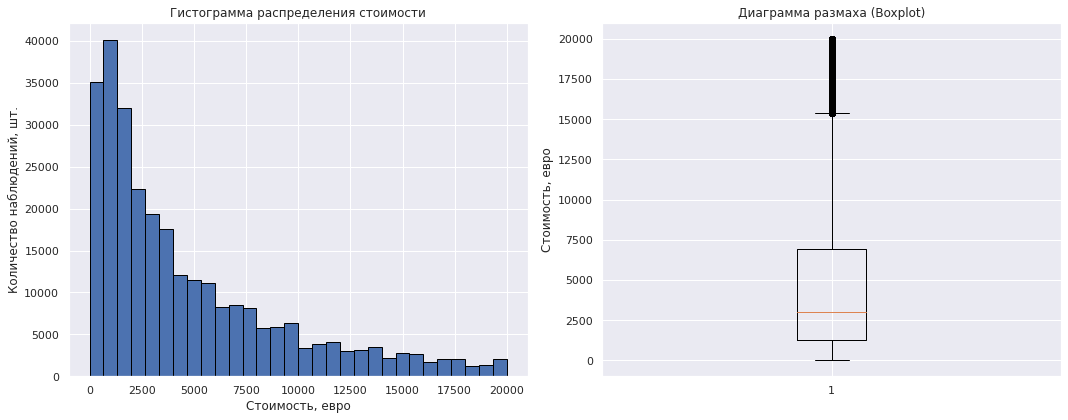

'Описательная статистика:'

count    283177.000000
mean       4748.075967
std        4618.164940
min           0.000000
25%        1250.000000
50%        3000.000000
75%        6900.000000
max       20000.000000
Name: Price, dtype: float64

'Дополнительные метрики:'

,Метрика,Значение
0,Минимальное значение,0.0
1,Нижняя граница (Q1-1.5*IQR),-7225.0
2,Количество выбросов снизу,0.0
3,Максимальное значение,20000.0
4,Верхняя граница (Q3+1.5*IQR),15375.0
5,Количество выбросов сверху,13067.0


In [59]:
# Создаем фигуру с двумя subplots (1 строка, 2 колонки)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Гистограмма на первом subplot (ax1)
ax1.hist(autos['Price'], bins=30, edgecolor='black')
ax1.set_title('Гистограмма распределения стоимости')
ax1.set_xlabel('Стоимость, евро')
ax1.set_ylabel('Количество наблюдений, шт.')
ax1.grid(True)

# Boxplot на втором subplot (ax2)
ax2.boxplot(autos['Price'])
ax2.set_title('Диаграмма размаха (Boxplot)')
ax2.set_ylabel('Стоимость, евро')
ax2.grid(True)

# Выводим графики
plt.tight_layout()
plt.show()

# Статистическое описание
Q1 = autos['Price'].quantile(0.25)
Q3 = autos['Price'].quantile(0.75)
IQR = Q3 - Q1

# Создаем DataFrame для красивого отображения статистики
stats_data = {
    'Метрика': ['Минимальное значение', 'Нижняя граница (Q1-1.5*IQR)', 
                'Количество выбросов снизу', 'Максимальное значение',
                'Верхняя граница (Q3+1.5*IQR)', 'Количество выбросов сверху'],
    'Значение': [
        autos['Price'].min(),
        Q1 - 1.5 * IQR,
        autos[autos['Price'] < (Q1 - 1.5 * IQR)].count().iloc[0],
        autos['Price'].max(),
        1.5 * IQR + Q3,
        autos[autos['Price'] > (1.5 * IQR + Q3)].count().iloc[0]
    ]
}

# Выводим описательную статистику и дополнительные метрики
display("Описательная статистика:")
display(autos['Price'].describe())
display("Дополнительные метрики:")
display(pd.DataFrame(stats_data))

Посмотрим на значения меньше 50 евро.

In [60]:
(autos.query('Price < 50').shape[0] / autos.shape[0]) * 100

2.297502975171006

Таких значений - 2.3%. Вряд ли в жизни найдутся такие авто, которые стоят меньше 50 евро. Удалим такие значения.

In [61]:
autos = autos.query('Price >= 50')

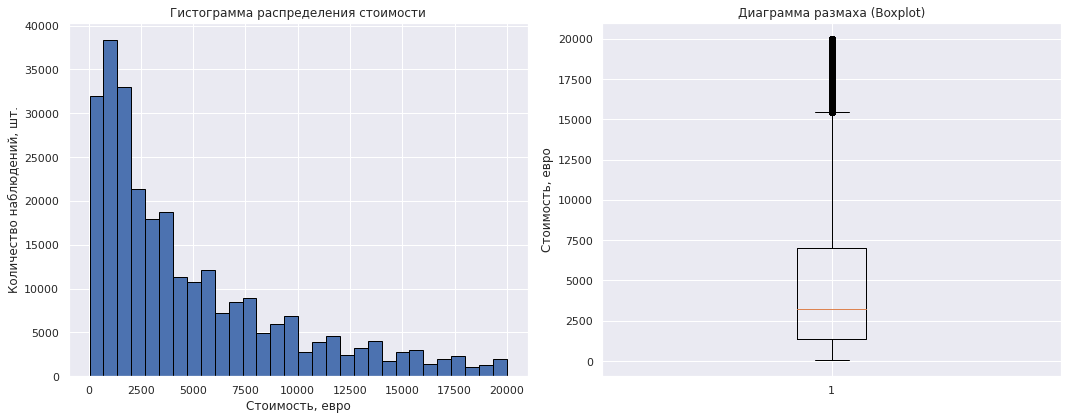

'Описательная статистика:'

count    276671.000000
mean       4859.718579
std        4613.725508
min          50.000000
25%        1350.000000
50%        3200.000000
75%        6990.000000
max       20000.000000
Name: Price, dtype: float64

'Дополнительные метрики:'

,Метрика,Значение
0,Минимальное значение,50.0
1,Нижняя граница (Q1-1.5*IQR),-7110.0
2,Количество выбросов снизу,0.0
3,Максимальное значение,20000.0
4,Верхняя граница (Q3+1.5*IQR),15450.0
5,Количество выбросов сверху,12882.0


In [62]:
# Создаем фигуру с двумя subplots (1 строка, 2 колонки)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Гистограмма на первом subplot (ax1)
ax1.hist(autos['Price'], bins=30, edgecolor='black')
ax1.set_title('Гистограмма распределения стоимости')
ax1.set_xlabel('Стоимость, евро')
ax1.set_ylabel('Количество наблюдений, шт.')
ax1.grid(True)

# Boxplot на втором subplot (ax2)
ax2.boxplot(autos['Price'])
ax2.set_title('Диаграмма размаха (Boxplot)')
ax2.set_ylabel('Стоимость, евро')
ax2.grid(True)

# Выводим графики
plt.tight_layout()
plt.show()

# Статистическое описание
Q1 = autos['Price'].quantile(0.25)
Q3 = autos['Price'].quantile(0.75)
IQR = Q3 - Q1

# Создаем DataFrame для красивого отображения статистики
stats_data = {
    'Метрика': ['Минимальное значение', 'Нижняя граница (Q1-1.5*IQR)', 
                'Количество выбросов снизу', 'Максимальное значение',
                'Верхняя граница (Q3+1.5*IQR)', 'Количество выбросов сверху'],
    'Значение': [
        autos['Price'].min(),
        Q1 - 1.5 * IQR,
        autos[autos['Price'] < (Q1 - 1.5 * IQR)].count().iloc[0],
        autos['Price'].max(),
        1.5 * IQR + Q3,
        autos[autos['Price'] > (1.5 * IQR + Q3)].count().iloc[0]
    ]
}

# Выводим описательную статистику и дополнительные метрики
display("Описательная статистика:")
display(autos['Price'].describe())
display("Дополнительные метрики:")
display(pd.DataFrame(stats_data))

С ценой мы ничего не сделаем - это целевой признак, и нам важно учесть в т.ч. выбросы по данному признаку. Мы видим, что распределение на гистограмме ненормальное (больше походит на распределение Пуассона).

Медианное значение составляет 3200 евро, среднее - 4860 евро. Поскольку у нас много выбросов - ориентируемся на медианное значение.

Перейдем к категориальным и дискретным признакам. Объявим вункцию, которая выводит барплоты, круговые диаграммы и сводуню таблицу.
Признак `Model` содержит больше 1000 наименований, мы выделим топ 5 моделей, остальное выведем в признаке `Другие`. Также признаки с датами и индексами почты мы рассмотрим отдельно.

In [63]:
cat_list = ['year_category', 'kilometer_category', 'NumberOfPictures', \
            'FuelType', 'Gearbox', 'VehicleType', 'power_category', 'Repaired']

In [64]:
def eda_cat_func(x, cat_list):
    
    for cat in cat_list:

        # Создаем фигуру с двумя subplots (1 строка, 2 колонки)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Первый график - столбчатая диаграмма на ax1
        sns.countplot(data=x, x=cat, ax=ax1)
        ax1.set_title(f'Столбчатая диаграмма по признаку {cat}')
        ax1.set_xlabel(f'Признак {cat}')
        ax1.set_ylabel('Кол-во объявляений, шт')

        # Подготовка данных для второго графика
        x_cat_pivot = x.pivot_table(index=[cat], values='Brand', aggfunc='count').reset_index()\
            .rename(columns={'Brand': 'Количество наблюдений, шт'})
        x_cat_pivot['Доля, %'] = round(x_cat_pivot['Количество наблюдений, шт'] / x['Brand'].count(), 2) * 100

        # Второй график - круговая диаграмма на ax2
        x_cat_pivot.plot(y='Доля, %', kind='pie', autopct='%1.1f%%', labels=None, ax=ax2, legend=False)
        ax2.set_title(f'Круговая диаграмма по признаку "{cat}"')
        ax2.set_ylabel('')  # Убираем лишнюю подпись оси y

        # Выводим легенду для круговой диаграммы
        plt.legend(x_cat_pivot[cat], loc="upper left", bbox_to_anchor=(1, 1))

        # Выводим сводную таблицу
        display(f"Сводная по признаку {cat}")
        display(x_cat_pivot)

        plt.tight_layout()  # Чтобы графики не накладывались друг на друга
        plt.show()

'Сводная по признаку year_category'

,year_category,"Количество наблюдений, шт","Доля, %"
0,1910-1985,3409,1.0
1,1985-1995,16331,6.0
2,1995-2005,145047,52.0
3,2005-2016,107957,39.0


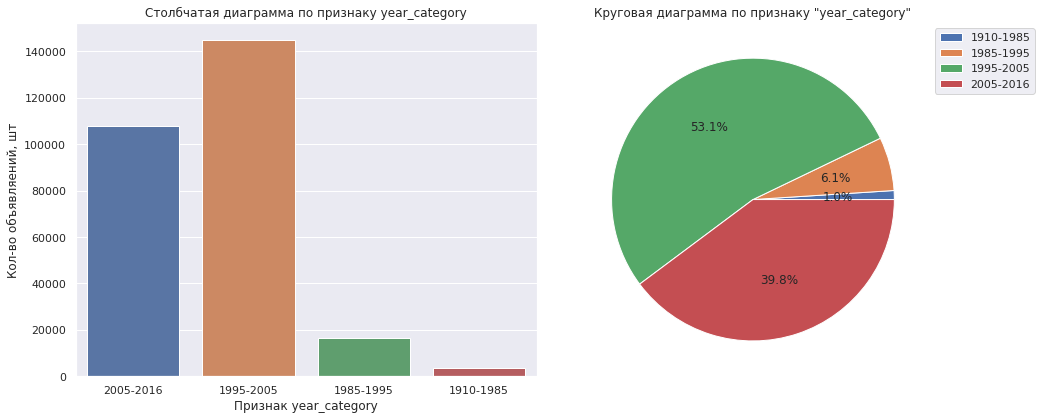

'Сводная по признаку kilometer_category'

,kilometer_category,"Количество наблюдений, шт","Доля, %"
0,100 000 - 150 000,225475,81.0
1,5 000 - 50 000,14264,5.0
2,50 000 - 100 000,36932,13.0


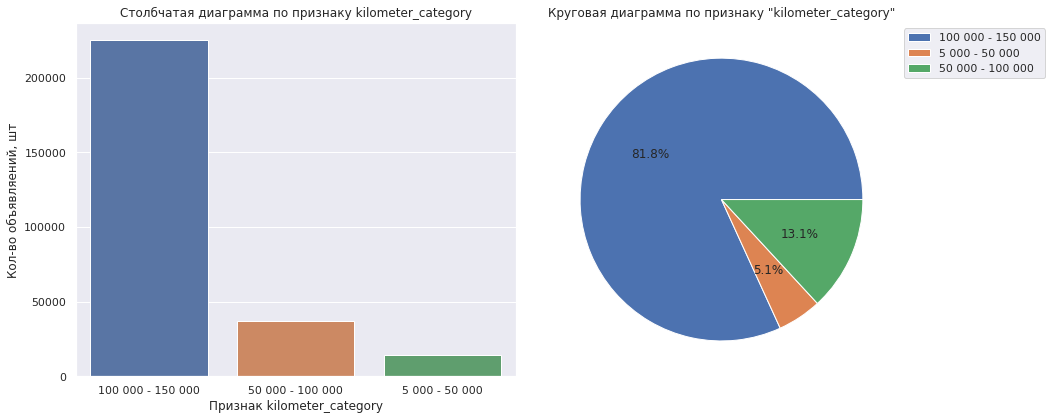

'Сводная по признаку NumberOfPictures'

,NumberOfPictures,"Количество наблюдений, шт","Доля, %"
0,0,276671,100.0


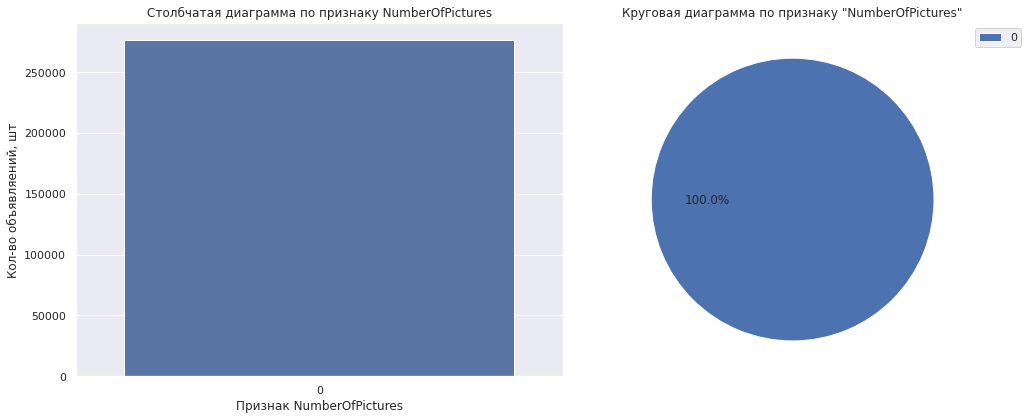

'Сводная по признаку FuelType'

,FuelType,"Количество наблюдений, шт","Доля, %"
0,cng,452,0.0
1,electric,41,0.0
2,gasoline,257884,93.0
3,hybrid,194,0.0
4,lpg,4355,2.0
5,other,13745,5.0


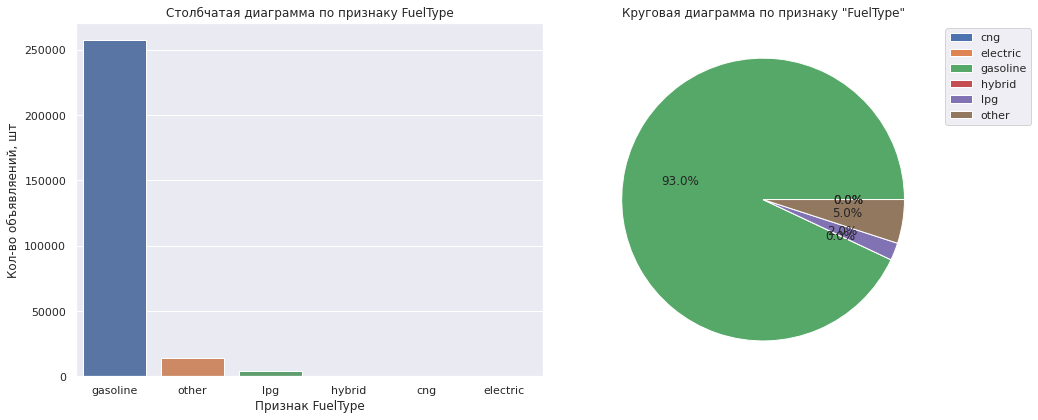

'Сводная по признаку Gearbox'

,Gearbox,"Количество наблюдений, шт","Доля, %"
0,auto,54784,20.0
1,manual,216861,78.0
2,not_defined,5026,2.0


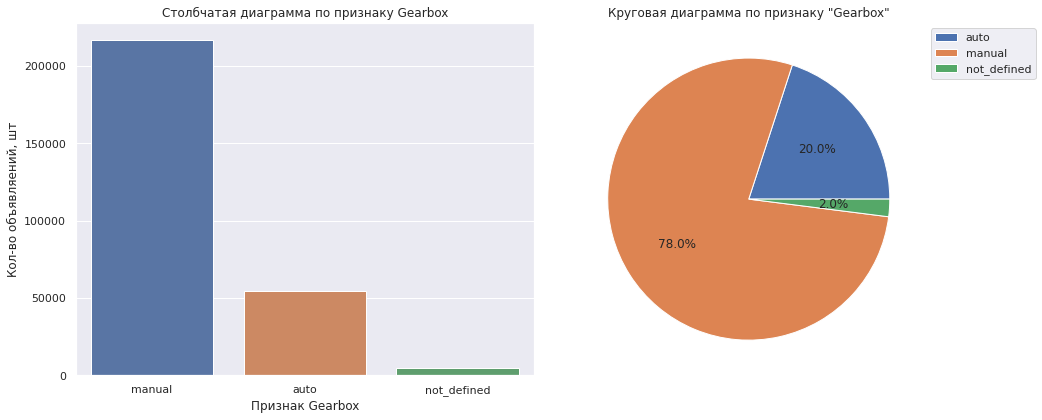

'Сводная по признаку VehicleType'

,VehicleType,"Количество наблюдений, шт","Доля, %"
0,bus,24793,9.0
1,convertible,17732,6.0
2,coupe,13867,5.0
3,other,9758,4.0
4,sedan,78465,28.0
5,small,66069,24.0
6,suv,10199,4.0
7,wagon,55788,20.0


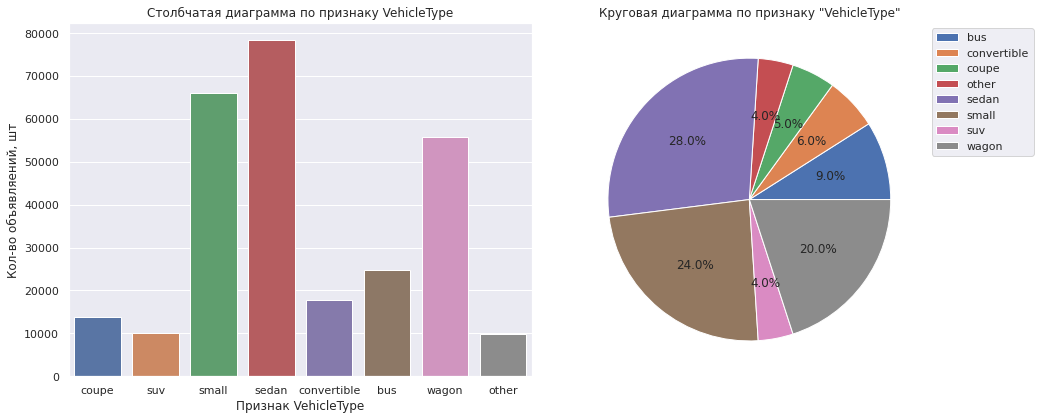

'Сводная по признаку power_category'

,power_category,"Количество наблюдений, шт","Доля, %"
0,100 - 200,155490,56.0
1,20 - 100,99161,36.0
2,200 - 300,18927,7.0
3,300 - 400,2587,1.0
4,400 - 500,297,0.0
5,>500,209,0.0


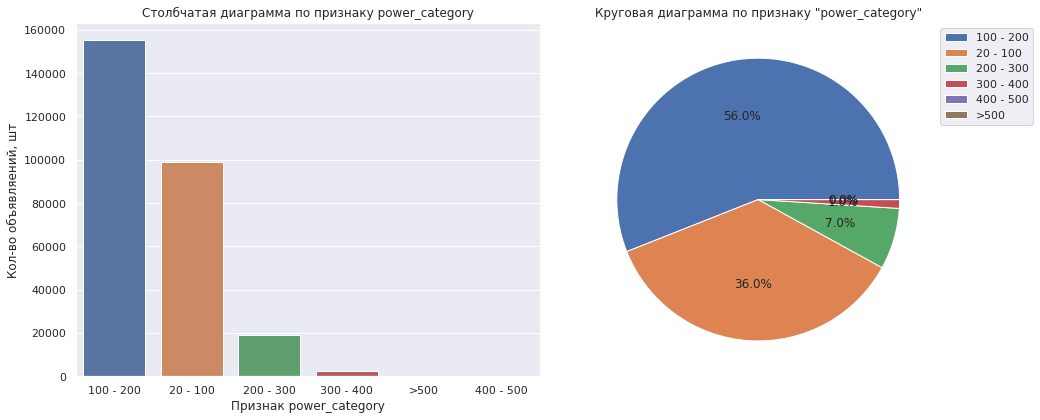

'Сводная по признаку Repaired'

,Repaired,"Количество наблюдений, шт","Доля, %"
0,no,209295,76.0
1,not_defined,40023,14.0
2,yes,27353,10.0


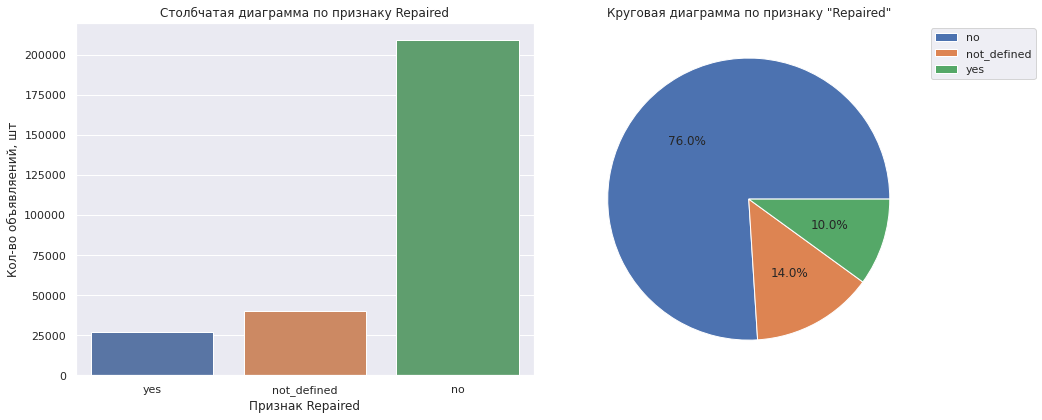

In [65]:
eda_cat_func(autos, cat_list)

Выводы:

1. Больше всего объявлений за период с 1995 по 2005 год - 52% или 145 047 шт, на втором месте период с 2005 по 2016 - 39% или 107 957 шт, на 3-м месте период с 1985 по 1995 год - 6% или 16 331 шт.
2. Мы разделили объявлении на категории по пробегу. Больше всего обявлений в категории `100 000 - 150 000` - 81% или 225 475 шт, на 2-м месте категория `50 000 - 100 000` - 13% или 36 932 шт. Меньше всего объявлений в категории `5 000 - 50 000` - 5% или 14 264 шт.
3. Ни в одном объявлении нет фоторгафий.
5. По признаку `FuelType` - больше всего автомобилей с типом топлива `gasoline` - 93% или 257 884 шт. В другие категории мы определили пустые значения, такие значения  составляют 5% или 13 745 шт. Самые непопулярные типы топлива: `lpg` - 1%, `hybrid`, `cng` и `electric`- менее 1% (538 шт и 87 шт соотвественно).
6. В данных у нас есть информация о коробке передач - МКПП, АКПП и другие. Самой популярной КП в наших данных является МКПП - 78% или 216 861 шт. На втором месте АКПП - 20% или 54 784 шт. К другим относится 2% данных или 5 026 шт.
7. Тип автомобильного кузова `VehicleType` - здесь представлено аж 7 типов кузова и 8-я категория `other`. Мы выделим всего 3 типа кузова: 1-й - sedan - 28%, 2-й - small - 24%, 3-й - wagon - 20%
8. Мы разделили Мощность дивгателя на категории, и большинство автомобилей обладают мощностью от 100 до 200 л.с. - 56%, 36% располагаются в диапазоне от 20 до 100 л.с.
9. В датасете 76% автомобилей не ремонтировалось, 14% - не определено, и 10% подвергалось ремонту.

Перейдем к признаку `Model`. Выделим топ-5 моделей автомобилей

In [66]:
apv = autos.pivot_table(index='Model', values='Brand', aggfunc='count')
apv.rename(columns={'Brand': 'Количество, шт'}, inplace=True)
apv.rename_axis(index={'Model': 'Модель'}, inplace=True)

apv['Соотношение, %'] = round(apv['Количество, шт'] / apv['Количество, шт'].sum(), 2) * 100
apv.sort_values(by='Соотношение, %', ascending=False).iloc[1:6]

,"Количество, шт","Соотношение, %"
Модель,,
golf,22999,8.0
3er,16298,6.0
polo,9964,4.0
corsa,9350,3.0
a4,8251,3.0


In [67]:
top_5_model = ['golf', '3er', 'corsa', 'polo', 'a4']

autos['model_category'] = [x if x in top_5_model else 'Другие' for x in autos['Model']]

,"Количество, шт","Соотношение, %"
Модель,,
Другие,209809,76.0
golf,22999,8.0
3er,16298,6.0
polo,9964,4.0
a4,8251,3.0
corsa,9350,3.0


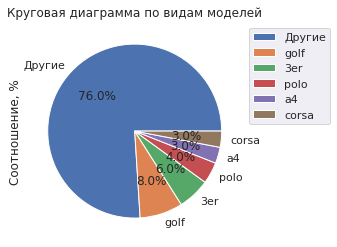

In [68]:
apv = autos.pivot_table(index='model_category', values='Brand', aggfunc='count')
apv.rename(columns={'Brand': 'Количество, шт'}, inplace=True)
apv.rename_axis(index={'model_category': 'Модель'}, inplace=True)

apv['Соотношение, %'] = round(apv['Количество, шт'] / apv['Количество, шт'].sum(), 2) * 100
display(apv.sort_values(by='Соотношение, %', ascending=False))
apv.sort_values(by='Соотношение, %', ascending=False).plot(y='Соотношение, %', kind='pie', autopct='%1.1f%%')
plt.title(f'Круговая диаграмма по видам моделей')
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

Посмотрим на признак PostalCode

In [69]:
len(autos['PostalCode'].unique())

8113

In [70]:
apv = autos.pivot_table(index='PostalCode', values='Brand', aggfunc='count')
apv.rename(columns={'Brand': 'Количество, шт'}, inplace=True)
apv.rename_axis(index={'PostalCode': 'Индекс'}, inplace=True)

apv['Соотношение, %'] = round(apv['Количество, шт'] / apv['Количество, шт'].sum(), 2) * 100
apv.sort_values(by='Соотношение, %', ascending=False)

,"Количество, шт","Соотношение, %"
Индекс,,
1067,69,0.0
75323,32,0.0
75391,16,0.0
75389,11,0.0
75387,17,0.0
...,...,...
37586,30,0.0
37581,24,0.0
37574,86,0.0


У нас здесь 8142 уникальных значения, и по каждому значению объявлений не более 1%. Поэтому данный признак мы в дальнейшем никак рассматривать не будем.

Даты, которые есть у нас в наличии, никак не влияют на стимость авто, поэтому их мы анализировать не будем.

In [72]:
#eda_cat_func_date(autos, date_list)

In [73]:
#1. 84% скачано из базы в марте 2016, остальные 16% - в апреле 2016.
#2. В эти же даты создано ольшинство объявлений на сайте: 84% объявлений в марте 2016, и 16% в апреле 2016.
#3. Последний раз пользователи заходили в марте 2016 и апреле 2016 - 43% и 57% соотвественно.

## 2.2 Корреляционный анализ

Перейдем к корреляционному анализу признаков. Мы будем использовать бибилиотеку phik, исключим из датасета категориальные значения, которые мы добавили, а также даты, почтовые индексы и количество картинок в объявлении. Они не несут никакой информации о корреляции стоимости автомобиля.

In [74]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276671 entries, 0 to 283176
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   DateCrawled         276671 non-null  datetime64[ns]
 1   Price               276671 non-null  int64         
 2   VehicleType         276671 non-null  object        
 3   RegistrationYear    276671 non-null  int64         
 4   Gearbox             276671 non-null  object        
 5   Power               276671 non-null  float64       
 6   Model               276671 non-null  object        
 7   Kilometer           276671 non-null  int64         
 8   FuelType            276671 non-null  object        
 9   Brand               276671 non-null  object        
 10  Repaired            276671 non-null  object        
 11  DateCreated         276671 non-null  datetime64[ns]
 12  NumberOfPictures    276671 non-null  int64         
 13  PostalCode          276671 no

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer']


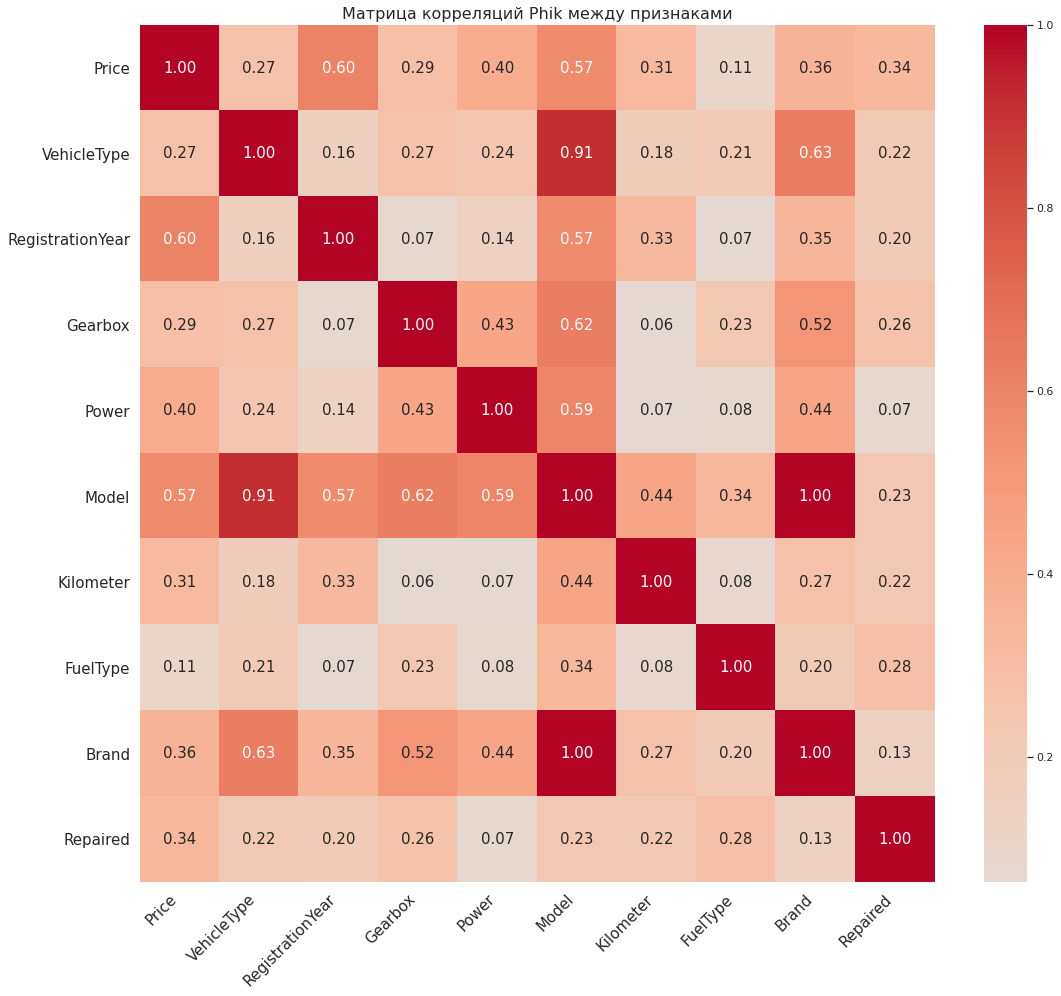

In [75]:
# Исключаем столбцы с датами и уникальными идентификаторами
exclude_cols = ['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode', 'NumberOfPictures']
autos_cleaned = autos.drop(columns=exclude_cols, errors='ignore')

autos_cleaned = autos_cleaned.drop(columns=['year_category', 'kilometer_category', 
                                      'power_category', 'model_category'], errors='ignore')

# Вычисление матрицы корреляций
corr_matrix = autos_cleaned.phik_matrix()

plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            center=0,
            annot_kws={"size": 15})

plt.title('Матрица корреляций Phik между признаками', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

**1. Главные драйверы цены (Price)**

RegistrationYear (0.60) - новые автомобили значительно дороже.

Model (0.57) и Brand (0.36) - конкретная модель важнее марки в целом.

Power (0.40) - мощность двигателя - значимый, но не решающий фактор.

**2. Сильные межпризнаковые связи**

Model - VehicleType (0.91) и Brand - VehicleType(0.63) - тип кузова определяются моделью, поэтому тип кузова можно не использовать при оубчении модели.

Model - Gearbox (0.62) и Model - Power (0.59) - конкретные модели обладают типом КПП и мощностью.

Brand - Gearbox (0.52) - марки также могут ассоциироваться с типами КПП

**3. Умеренные корреляции с ценой**

Repaired (0.34) - тут можно **проверит гипотезу о том, что стоимость автомобилей с ремонтом ниже, чем без ремонта.**

Kilometer (0.31) - пробег влияет на цену слабее, чем год выпуска. Объяснение: 10-летний авто с малым пробегом может быть дороже 5-летнего "такси".

Gearbox (0.29) - Автоматические КПП лишь немного увеличивают стоимость.

**4. Слабые корреляции**

FuelType (0.11) - тип топлива минимально влияет на цену.

VehicleType (0.27) - можно оставить признак Model (Brand)

**Что можно сделать:**
1. Добавить новый признак model + brand
2. Оставить следующие признаки: RegistrationYear, Power, Kilometer.
3. Если гипотеза о равенстве стоимости из-за ремнота не будет отвергнута, то добавить Repaired в данные.

### 2.2.1 Проверка гипотезы о равенстве средних

In [76]:
price_repaired = autos.query('Repaired == "yes"')['Price']
price_repaired
f'Среднее значение стоимости автомобилей с ремонтом: {np.mean(price_repaired)}'

'Среднее значение стоимости автомобилей с ремонтом: 2170.886045406354'

In [77]:
price_non_repaired = autos.query('Repaired == "no"')['Price']
price_non_repaired
f'Среднее значение стоимости автомобилей без ремонта: {np.mean(price_non_repaired)}'

'Среднее значение стоимости автомобилей без ремонта: 5534.005451635252'

Мы знаем, что у нас в данных по признаку ремнота есть дисбаланс. Поэтому будем использовать технику бутстреп - сделаем выборки, по каждой посчитаем среднее и посмотрим разницу.

Гипотезы:

H0 - средние значения стоимостей автомобилей с ремонтом и без одинаковое

H1 - средние значения стоимостей автомобилей не равны

In [78]:
autos_deleted = autos.query('Repaired != "not_defined"')

In [79]:
def bootstrap_means_test(price_repaired, price_non_repaired, n_iterations=1000):
    effect_sizes = []
    combined_mean = np.mean(np.concatenate([price_repaired, price_non_repaired]))
    
    for _ in range(n_iterations):
        # Ресемплинг с заменой
        sample1 = np.random.choice(price_repaired, size=len(price_repaired), replace=True)
        sample2 = np.random.choice(price_non_repaired, size=len(price_non_repaired), replace=True)
        
        # Разница средних
        effect_size = np.mean(sample1) - np.mean(sample2)
        effect_sizes.append(effect_size)
    
    # Доверительный интервал
    ci_lower = np.percentile(effect_sizes, 2.5)
    ci_upper = np.percentile(effect_sizes, 97.5)
    
    # Проверка гипотезы
    p_value = 2 * min(
        np.mean(np.array(effect_sizes) <= 0),
        np.mean(np.array(effect_sizes) >= 0)
    )
    
    return effect_sizes, ci_lower, ci_upper, p_value

# Запуск теста
effect_sizes, ci_lower, ci_upper, p_value = bootstrap_means_test(
    price_repaired, price_non_repaired, n_iterations=10000
)

print(f"Результаты бутстреп-теста:")
print(f"Средняя разница: {np.mean(effect_sizes):.2f}")
print(f"95% доверительный интервал: [{ci_lower:.2f}, {ci_upper:.2f}]")
print(f"p-value: {p_value:.5f}")

Результаты бутстреп-теста:
Средняя разница: -3363.01
95% доверительный интервал: [-3401.92, -3325.14]
p-value: 0.00000


Статистически значимые различия в средней цене автомобилей в зависимости от факта ремонта обнаружены. 

Автомобили, которые ремонтировались (Repaired="yes"), в среднем дешевле на 3363 евро (95% ДИ: 3402-3324 евро), чем автомобили без ремонта (Repaired="no"). 

Эта разница является как статистически значимой (p < 0.001), так и экономически существенной. Соответственно, мы отвергаем нулевую гипотезу о равенстве средний значений стоимостей автомобилей с ремонтом и без.

Поэтому мы включим данный признак в модель.

Добавим новый признак в данные: `Brand` + `Model`. Там, где `Model` неизвестна, оставим значения `Brand`.

In [80]:
autos['Brand_Model'] = np.where(
    (autos['Model'].notna()) & (~autos['Model'].str.lower().eq('other')),
    autos['Brand'] + ' ' + autos['Model'],
    autos['Brand']
)

autos.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,year_category,kilometer_category,power_category,model_category,Brand_Model
0,2016-03-01,18300,coupe,2011,manual,190.0,other,125000,gasoline,audi,yes,2016-03-01,0,66954,2016-04-01,2005-2016,100 000 - 150 000,100 - 200,Другие,audi
1,2016-03-01,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,not_defined,2016-03-01,0,90480,2016-04-01,1995-2005,100 000 - 150 000,100 - 200,Другие,jeep grand
2,2016-03-01,1500,small,2001,manual,75.0,golf,150000,gasoline,volkswagen,no,2016-03-01,0,91074,2016-03-01,1995-2005,100 000 - 150 000,20 - 100,golf,volkswagen golf
3,2016-03-01,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no,2016-03-01,0,60437,2016-04-01,2005-2016,50 000 - 100 000,20 - 100,Другие,skoda fabia
4,2016-04-01,650,sedan,1995,manual,102.0,3er,150000,gasoline,bmw,yes,2016-04-01,0,33775,2016-04-01,1995-2005,100 000 - 150 000,100 - 200,3er,bmw 3er


Данные добавили, проведем еще один корреляционный анализ.

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer']


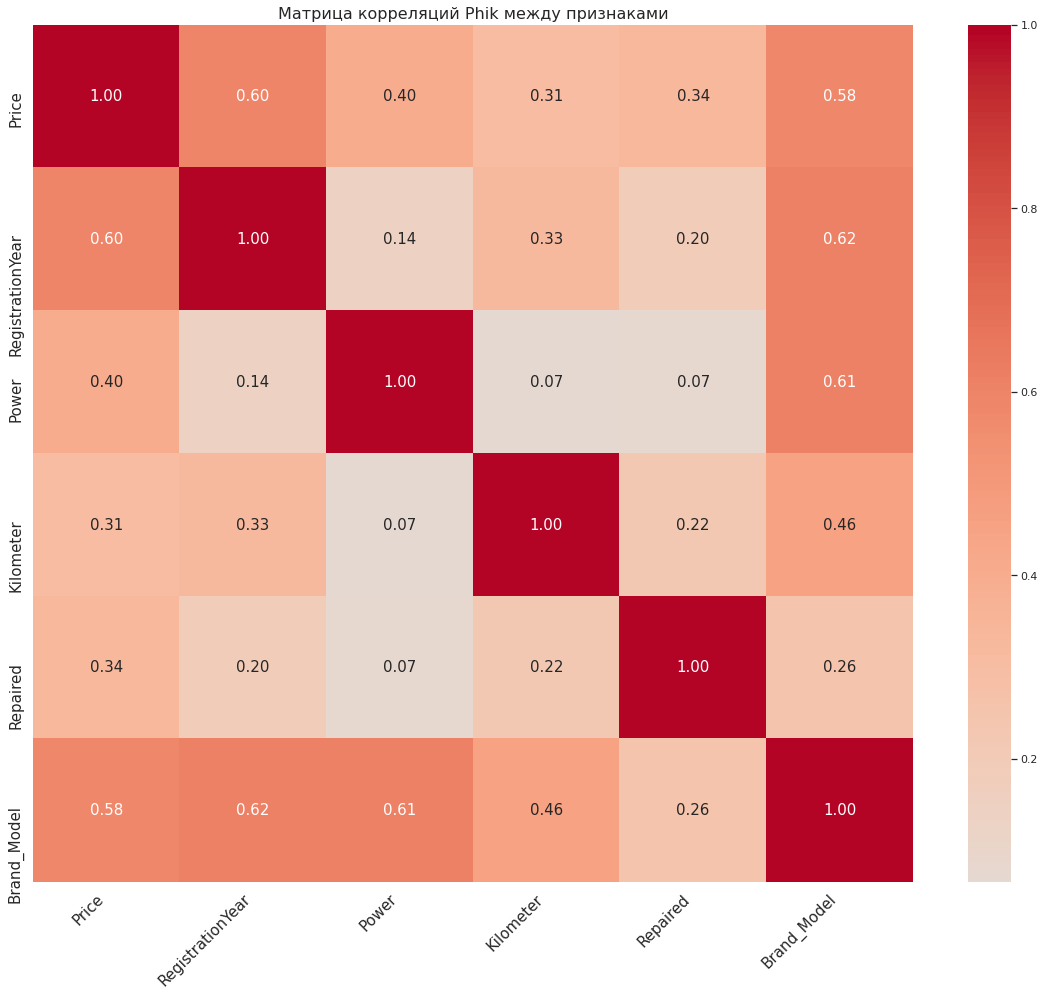

In [81]:
exclude_cols = ['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode', 'NumberOfPictures']
autos_cleaned = autos.drop(columns=exclude_cols, errors='ignore')

autos_cleaned = autos_cleaned.drop(columns=['year_category', 'kilometer_category', \
                                      'power_category', 'model_category', 'Model', 'Brand',\
                                            'Gearbox', 'VehicleType', 'RegistrationMonth', 'FuelType'], errors='ignore')

# Вычисление матрицы корреляций
corr_matrix = autos_cleaned.phik_matrix()

plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            center=0,
            annot_kws={"size": 15})

plt.title('Матрица корреляций Phik между признаками', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

Мы видим, что у автомобиля есть корреляция с мощностью. Однако мы не сможем определить тип зависимости как линейны, т.к. у нас очень много категорий в этом признаке.

## 3. Подготовка данных для обучения моделей

Возьмем датасет, исключим из него данные, которые мы не будем использовать для обучения.

In [83]:
exclude_cols = ['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode', 'NumberOfPictures', 'year_category', \
                'kilometer_category', 'power_category', 'model_category', 'Model', 'Brand', \
                'Gearbox', 'VehicleType', 'RegistrationMonth', 'FuelType']

autos_cleaned = autos.drop(columns=exclude_cols, errors='ignore')

Проверим данные на дубликаты и удалим их при наличии

In [84]:
autos_cleaned.duplicated().sum()

39479

In [85]:
autos_cleaned = autos_cleaned.drop_duplicates(keep='first').reset_index(drop=True)

In [86]:
autos_cleaned.head(5)

,Price,RegistrationYear,Power,Kilometer,Repaired,Brand_Model
0,18300,2011,190.0,125000,yes,audi
1,9800,2004,163.0,125000,not_defined,jeep grand
2,1500,2001,75.0,150000,no,volkswagen golf
3,3600,2008,69.0,90000,no,skoda fabia
4,650,1995,102.0,150000,yes,bmw 3er


In [87]:
# объявим константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

Поскольку у нас нет разделения на тренирвочную и тестовую выборки, разделим над датасет на три выборки.

In [88]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    """Кастомный трансформер для частотного кодирования"""
    def __init__(self):
        self.freq_dict = {}
    
    def fit(self, X, y=None):
        # X - это DataFrame
        self.freq_dict = X.iloc[:, 0].value_counts(normalize=True).to_dict()
        return self
    
    def transform(self, X):
        # Применяем map к конкретному столбцу
        encoded = X.iloc[:, 0].map(self.freq_dict).fillna(0).values.reshape(-1, 1)
        return encoded

In [89]:
def prepare_data(x):

    X = x.drop(['Price'], axis=1) # выделяем входные признаки
    y = x['Price'] # выделяем целевой признак

    # делим датасет на тренировочную, валидационную и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size = TEST_SIZE, 
        random_state=RANDOM_STATE
    )
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train,
        y_train,
        test_size = TEST_SIZE,
        random_state = RANDOM_STATE
    )

    # масштабируем и кодируем входные признаки
    
    num_cols_names = ['RegistrationYear', 'Power', 'Kilometer']
    catcols_names = ['Repaired']
    high_features = ['Brand_Model']
    
    preprocessor = ColumnTransformer(
            transformers=[
                # Масштабирование числовых признаков
                ('num', StandardScaler(), num_cols_names),

                # КОдирование с помощью OneHotEncoder
              ('cat', OneHotEncoder(
                    categories=[['not_defined', 'no', 'yes']],
                    drop='first',  # избегаем дамми-ловушку
                    sparse_output=False
                ), catcols_names),

                # Частотное кодирование для Brand_model
                ('high_card', Pipeline([
                    ('encoder', FrequencyEncoder()),
                    ('scaler', StandardScaler())
                ]), high_features)
            ],
            remainder='drop'  # Игнорируем остальные колонки, если есть
        )
    
    # обучаем и трансформируем выборки

    X_train = preprocessor.fit_transform(X_train)
    X_valid = preprocessor.transform(X_valid)
    X_test = preprocessor.transform(X_test)
    
    # преобразуем в датасеты
    high_features = ['Brand_Model_freq']
    catcols_names = preprocessor.named_transformers_['cat'].get_feature_names_out(['Repaired'])
    
    feature_names = num_cols_names + list(catcols_names) + high_features
    X_train = pd.DataFrame(X_train, columns=feature_names)
    X_valid = pd.DataFrame(X_valid, columns=feature_names)
    X_test = pd.DataFrame(X_test, columns=feature_names)
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [90]:
X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_data(autos_cleaned)

In [91]:
X_train.head(5)

,RegistrationYear,Power,Kilometer,Repaired_no,Repaired_yes,Brand_Model_freq
0,0.784230,0.794688,0.626762,1.0,0.0,-0.806958
1,-2.685874,-0.736204,0.626762,1.0,0.0,-0.757635
2,-0.121015,2.308757,-1.746549,1.0,0.0,-0.887738
3,-0.573637,-0.820318,0.626762,0.0,1.0,-0.354123
4,-1.629756,14.757765,-2.801354,1.0,0.0,0.240465


In [92]:
X_valid.head(5)

,RegistrationYear,Power,Kilometer,Repaired_no,Repaired_yes,Brand_Model_freq
0,1.236852,-0.046461,-2.010251,1.0,0.0,-0.581706
1,0.482482,-0.904433,0.626762,0.0,1.0,0.589218
2,0.180733,-0.113753,-0.032491,1.0,0.0,1.820726
3,0.935104,-0.231514,-2.273952,1.0,0.0,-0.576657
4,0.784230,0.794688,0.626762,1.0,0.0,0.466882


In [93]:
y_train.head(5)

126708    12000
166204     1950
50839     18999
150139      350
93918        50
Name: Price, dtype: int64

In [94]:
y_valid.head(5)

210739    11800
174549     1650
167103     3999
70943     10990
190463     5499
Name: Price, dtype: int64

Данные мы подготовили, перейдем к обучению моделей.

## 4. Обучение моделей

Поскольку у нас здесь задача регрессии, мы будем использовать следующие модели:

1. LinearRegression()
2. DesicionTreeRegressor()
3. LGBMRegressor()

Начнем с простой модели линейной регрессии.

## 4.1 LinearRegression

In [95]:
%%time

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

CPU times: user 22.7 ms, sys: 7.97 ms, total: 30.6 ms
Wall time: 47.6 ms


LinearRegression()

In [96]:
%%time

predictions = model_lr.predict(X_valid)

CPU times: user 47.8 ms, sys: 36.9 ms, total: 84.7 ms
Wall time: 91.8 ms


In [97]:
# предсказания на валидационной выборке
rmse = root_mean_squared_error(y_valid, predictions)
rmse

3320.544867506625

## 4.2 DecisionTreeRegressor

Для определния лучшей модели будем использвать кросс-валидацию RandomizedSearchCV

In [99]:
# словарь с гиперпараметрами
param_dist = {
    'max_depth': range(10, 15),              # Смотрим значения от 10 до 15
    'min_samples_split': range(2, 9),      # От 2 до 9
    'min_samples_leaf': range(10, 15),       # От 10 до 15
    'max_features': ['auto', 'sqrt', 'log2']  # Стратегии выбора признаков
}

# инициализация модели
model_dt = DecisionTreeRegressor(random_state=RANDOM_STATE)

# Настройка RandomizedSearch
random_search = RandomizedSearchCV(
    estimator=model_dt,
    param_distributions=param_dist,
    n_iter=50,                # Количество комбинаций
    cv=5,                     # 3 фолда
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,                # Использовать все ядра
    verbose=1,
    random_state=42,
    return_train_score=True
)

In [101]:
print("Лучшие параметры:", random_search.best_params_)
print("Лучший RMSE:", -random_search.best_score_)

Лучшие параметры: {'min_samples_split': 2, 'min_samples_leaf': 13, 'max_features': 'log2', 'max_depth': 14}
Лучший RMSE: 2136.973604242171


In [102]:
%%time

best_model = random_search.best_estimator_
predictions = best_model.predict(X_valid)

CPU times: user 8.73 ms, sys: 24 µs, total: 8.76 ms
Wall time: 8.06 ms


In [103]:
# предсказания на валидационной выборке
rmse  = root_mean_squared_error(y_valid, predictions)
print(f"RMSE на валидации: {rmse:.2f}")

RMSE на валидации: 2122.20


## 4.3 LGBMRegressor

In [105]:
X_train.head(5)

,RegistrationYear,Power,Kilometer,Repaired_no,Repaired_yes,Brand_Model_freq
0,0.784230,0.794688,0.626762,1.0,0.0,-0.806958
1,-2.685874,-0.736204,0.626762,1.0,0.0,-0.757635
2,-0.121015,2.308757,-1.746549,1.0,0.0,-0.887738
3,-0.573637,-0.820318,0.626762,0.0,1.0,-0.354123
4,-1.629756,14.757765,-2.801354,1.0,0.0,0.240465


Прежде, чем объявлять и обучать модель, нам нужно подготовить датасеты особым образом.

In [106]:
repaired_features = [col for col in X_train.columns if col.startswith('Repaired_')]
categorical_features = repaired_features

# Создаем Dataset для LightGBM
train_data = lgb.Dataset(
    X_train, label=y_train,
    categorical_feature=categorical_features,
    free_raw_data=False
)

val_data = lgb.Dataset(
    X_valid, label=y_valid,
    categorical_feature=categorical_features,
    free_raw_data=False
)

In [107]:
%%time

model_lgb = lgb.train(
    {'objective': 'regression',
    'random_state': 42,
    'learning_rate': 0.3,
    'metric':'rmse',
    'force_row_wise':True},
    train_set = train_data, valid_sets=[val_data]
)

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Total Bins 502
[LightGBM] [Info] Number of data points in the train set: 133420, number of used features: 6


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score 5072.228017
[1]	valid_0's rmse: 3719.41
[2]	valid_0's rmse: 3102.19
[3]	valid_0's rmse: 2716.56
[4]	valid_0's rmse: 2474.13
[5]	valid_0's rmse: 2325.9
[6]	valid_0's rmse: 2240.04
[7]	valid_0's rmse: 2178.3
[8]	valid_0's rmse: 2124.96
[9]	valid_0's rmse: 2094.41
[10]	valid_0's rmse: 2068.66
[11]	valid_0's rmse: 2033.65
[12]	valid_0's rmse: 2019.59
[13]	valid_0's rmse: 2001.94
[14]	valid_0's rmse: 1987.25
[15]	valid_0's rmse: 1981.04
[16]	valid_0's rmse: 1972.67
[17]	valid_0's rmse: 1957.68
[18]	valid_0's rmse: 1950.27
[19]	valid_0's rmse: 1939.02
[20]	valid_0's rmse: 1932.73
[21]	valid_0's rmse: 1926.28
[22]	valid_0's rmse: 1921.46
[23]	valid_0's rmse: 1920.81
[24]	valid_0's rmse: 1915.24
[25]	valid_0's rmse: 1909.65
[26]	valid_0's rmse: 1906.3
[27]	valid_0's rmse: 1901.23
[28]	valid_0's rmse: 1898.02
[29]	valid_0's rmse: 1893.29
[30]	valid_0's rmse: 1883.06
[31]	valid_0's rmse: 1878.96
[32]	valid_0's rmse: 1876.18
[33]	valid_0's rmse: 1871.45

In [108]:
%%time

predictions = model_lgb.predict(X_valid)

CPU times: user 288 ms, sys: 0 ns, total: 288 ms
Wall time: 304 ms


In [109]:
# предсказания на валидационной выборке
rmse = root_mean_squared_error(y_valid, predictions)
rmse

1773.140376567436

In [110]:
# предсказания на тестовой выборке
#predictions = model_lgb.predict(X_test)
#rmse = root_mean_squared_error(y_test, predictions)
#rmse

## 5. Выбор модели

Для выбора оптимальной модели оформить данные в вывод и выведем визуально метрики по каждой модели.

In [111]:
data = {
    'Model': ['LinearRegression', 'DecisionTreeRegressor', 'LGBMRegressor'],
    'Train_CPU_Time_ms': [31.9, 15200, 30100],
    'Train_Wall_Time_ms': [25.1, 15600, 30300],
    'Predict_CPU_Time_ms': [33.7, 8.67, 264],
    'Predict_Wall_Time_ms': [8.07, 7.97, 211],
    'Validation_RMSE': [3320.54, 2122.20, 1773.14]
}

results_df = pd.DataFrame(data)

# Форматируем вывод
pd.options.display.float_format = '{:.2f}'.format
results_df.set_index('Model', inplace=True)

print("Сравнение моделей:")
results_df

Сравнение моделей:


,Train_CPU_Time_ms,Train_Wall_Time_ms,Predict_CPU_Time_ms,Predict_Wall_Time_ms,Validation_RMSE
Model,,,,,
LinearRegression,31.90,25.10,33.70,8.07,3320.54
DecisionTreeRegressor,15200.00,15600.00,8.67,7.97,2122.20
LGBMRegressor,30100.00,30300.00,264.00,211.00,1773.14


In [112]:
2122.20 - 1773.14

349.0599999999997

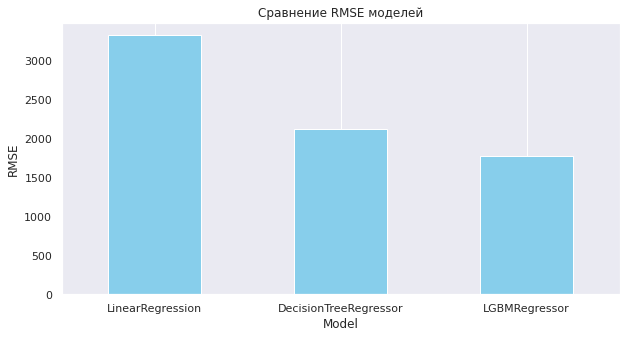

<Figure size 720x360 with 0 Axes>

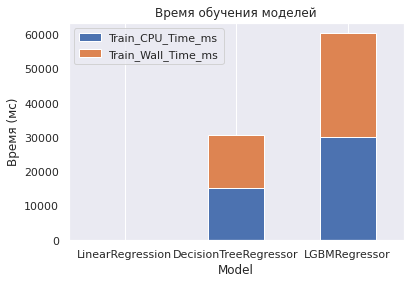

In [113]:
# График сравнения RMSE
plt.figure(figsize=(10, 5))
results_df['Validation_RMSE'].plot(kind='bar', color='skyblue')
plt.title('Сравнение RMSE моделей')
plt.ylabel('RMSE')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

# График времени обучения
plt.figure(figsize=(10, 5))
results_df[['Train_CPU_Time_ms', 'Train_Wall_Time_ms']].plot(kind='bar', stacked=True)
plt.title('Время обучения моделей')
plt.ylabel('Время (мс)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

Поскольку нам необходимо учитывать как время предсказания, так и метрику RMSE, то в данном случае оптимально было бы выбрать DecisionTreeRegressor. Времени на обучение по сравнению с LGBMRegressor уходит меньше, но при этом разница в метриках составляет 350 евро (в пользу LGB).

Посчитаем RMSE на тестовой выборке

In [114]:
predictions = best_model.predict(X_test)
rmse = root_mean_squared_error(y_test, predictions)
print(f'RMSE на тестовой выборке лучшей модели DecisonTree: {rmse:.2f}')

RMSE на тестовой выборке лучшей модели DecisonTree: 2126.31


## Выводы

**1. Загрузка и обработка данных**

При обработке данных мы обнаружили и обработали пропущенные значения в датасете - в категориальных признаках заменили там, где возможно, на значения `other` (`VehicleType` и `FuelType`, `Model`), там, где заглушек не предполагалось, заменили пропуски на `not_defined` (не определено) (`Repaired`, `Gearbox`)

Также мы обнаружили аномальные значения в признаках:
- `RegistrationYear` - мы приняли решение анализировать значения от 1910 до 2016 года.
- `Power` - были значения выше 1500 л.с. (от 1500 и вплоть до 20 000 л.с.) и меньше 20 л.с. Мы анализировади диапазон от 20 до 1500 л.с.
- `Price` - мы столкнулись с ошибками, встречлаись цены 0, 1 и т.д. евро. Мы приянл решение ограничить стоимость и удалить значения меньше 50 евро.

**2. Исследовательский анализ данных**

Поскольку у нас много дискретных количественных признаков, мы приняли решение составить новые признаки, сделав их категориальными (например, для признака `RegistrationYear` мы разбили данные с 1910 по 2019 год), и вот что у нас вышло.

- `Price` - это целевой признак, и нам важно учесть в т.ч. выбросы по данному признаку. Мы видим, что распределение на гистограмме ненормальное (больше походит на распределение Пуассона). Медианное значение составляет 3200 евро, среднее - 4860 евро. Поскольку у нас много выбросов - ориентируемся на медианное значение.

- `RegistrationYear`- Больше всего объявлений за период с 1995 по 2005 год - 52% или 145 047 шт, на втором месте период с 2005 по 2016 - 39% или 107 957 шт, на 3-м месте период с 1985 по 1995 год - 6% или 16 331 шт.

- `Kilometer` - Мы разделили объявлении на категории по пробегу. Больше всего обявлений в категории `100 000 - 150 000` - 81% или 225 475 шт, на 2-м месте категория `50 000 - 100 000` - 13% или 36 932 шт. Меньше всего объявлений в категории `5 000 - 50 000` - 5% или 14 264 шт.

- `NumberOfPictures` - Ни в одном объявлении нет фоторгафий.

- `FuelType` - больше всего автомобилей с типом топлива `gasoline` - 93% или 257 884 шт. В другие категории мы определили пустые значения, такие значения  составляют 5% или 13 745 шт. Самые непопулярные типы топлива: `lpg` - 1%, `hybrid`, `cng` и `electric`- менее 1% (538 шт и 87 шт соотвественно).

- `Gearbox` - В данных у нас есть информация о коробке передач - МКПП, АКПП и другие. Самой популярной КП в наших данных является МКПП - 78% или 216 861 шт. На втором месте АКПП - 20% или 54 784 шт. К другим относится 2% данных или 5 026 шт.

- Тип автомобильного кузова `VehicleType` - здесь представлено аж 7 типов кузова и 8-я категория `other`. Мы выделим всего 3 типа кузова: 1-й - sedan - 28%, 2-й - small - 24%, 3-й - wagon - 20%

- Мы разделили Мощность дивгателя на категории, и большинство автомобилей обладают мощностью от 100 до 200 л.с. - 56%, 36% располагаются в диапазоне от 20 до 100 л.с.

- `Repaired` - В датасете 76% автомобилей не ремонтировалось, 14% - не определено, и 10% подвергалось ремонту.

Признаки почтового индекса и месяца мы не рассматривали, т.к. они не влияют на стоимость авто.

- `Model` - мы выделили топ 5 уникальных моделей среди всех данных. Вот, что мы выяснили:

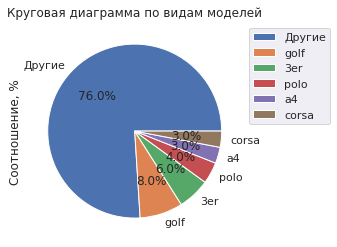

**2.1 Корреляционный анализ**

Затем мы провели корреляционный анализ признаков, и вот, что выяснили:

**1. Главные драйверы цены (Price)**

- RegistrationYear (0.60) - новые автомобили значительно дороже.

- Model (0.57) и Brand (0.36) - конкретная модель важнее марки в целом.

- Power (0.40) - мощность двигателя - значимый, но не решающий фактор.

**2. Сильные межпризнаковые связи**

- Model - VehicleType (0.91) и Brand - VehicleType(0.63) - тип кузова определяются моделью, поэтому тип кузова можно не использовать при оубчении модели.

- Model - Gearbox (0.62) и Model - Power (0.59) - конкретные модели обладают типом КПП и мощностью.

- Brand - Gearbox (0.52) - марки также могут ассоциироваться с типами КПП

**3. Умеренные корреляции с ценой**

- Repaired (0.34) - тут можно **проверит гипотезу о том, что стоимость автомобилей с ремонтом ниже, чем без ремонта.**

- Kilometer (0.31) - пробег влияет на цену слабее, чем год выпуска. Объяснение: 10-летний авто с малым пробегом может быть дороже 5-летнего "такси".

- Gearbox (0.29) - Автоматические КПП лишь немного увеличивают стоимость.

**4. Слабые корреляции**

- FuelType (0.11) - тип топлива минимально влияет на цену.

- VehicleType (0.27) - можно оставить признак Model (Brand)

По итогу мы решили сделать следующее:

1. Добавить новый признак model + brand
2. Оставить следующие признаки: RegistrationYear, Power, Kilometer.
3. Если гипотеза о равенстве стоимости из-за ремнота не будет отвергнута, то добавить Repaired в данные.

Также мы проверили гипотезы:

H0 - средние значения стоимостей автомобилей с ремонтом и без одинаковое

H1 - средние значения стоимостей автомобилей не равны

с помощью техники бутстреп: Автомобили, которые ремонтировались (Repaired="yes"), в среднем дешевле на 3363 евро (95% ДИ: 3402-3324 евро), чем автомобили без ремонта (Repaired="no"). Эта разница является  статистически значимой (p < 0.001)ю Соответственно, мы отвергаем нулевую гипотезу о равенстве средний значений стоимостей автомобилей с ремонтом и без. Поэтому мы включим данный признак в модель.

**3. Подготовка данных для обучения**

Мы оставили в финальной версии признаки `Brand_Model`, `RegistrationYear`, `Kilometer`, `Power`, `Repaired`.

Поскольку в признаке с моделями и брендами у нас много уникальных значений (больше 10), мы решили применить к данному признаку частотное кодирование. Ввиду конфликта версий sklearn и category_encoders мы использовали кастомный трансформер для частотного кодирования. Затем мы объявили в функцию, в которой реализовали подготовку датасета - совместили деление на выборки, а также масштабирование и кодирование признаков

**4. Обучение моделей**

Мы решили использовать 3 вида моделей в данной задаче - LinearRegression, DecisionTreeRegressor, LGBMRegressor, и вот, какие данные у нас получились:

| Модель               | Гиперпараметры                                                                 | Обучение (CPU) | Обучение (Wall) | Предсказание (CPU) | Предсказание (Wall) | RMSE валидации | Улучшение vs Linear | Улучшение LGBM vs DT |
|----------------------|--------------------------------------------------------------------------------|---------------:|----------------:|-------------------:|--------------------:|---------------:|-------------------:|--------------------:|
| **LinearRegression** | `-`                                                                           |        31.9 ms |         25.1 ms |            33.7 ms |             8.07 ms |       3320.54 |              0.00% |                   - |
| **DecisionTree**     | `max_depth=14`<br>`min_samples_split=2`<br>`min_samples_leaf=13`<br>`max_features='log2'` |      15.2 s |       15.6 s |          8.67 ms |           7.97 ms |       2122.20 |             36.00% |                   - |
| **LGBMRegressor**    | `objective='regression'`<br>`random_state=42`<br>`learning_rate=0.3`<br>`metric='rmse'`       |      30.1 s |       30.3 s |        264 ms |         211 ms |       1773.14 |             47.00% |             16.45% |

Поскольку нам необходимо учитывать как время обучения, так и метрику RMSE, то в данном случае оптимально было бы выбрать DecisionTreeRegressor. Времени на обучение по сравнению с LGBMRegressor уходит меньше, но при этом разница в метриках составляет 350 евро (в пользу LGB).

Таким образом, RMSE лучшей модели на тестовой выборке составила 2126.31 евро.